# Fabricate data

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


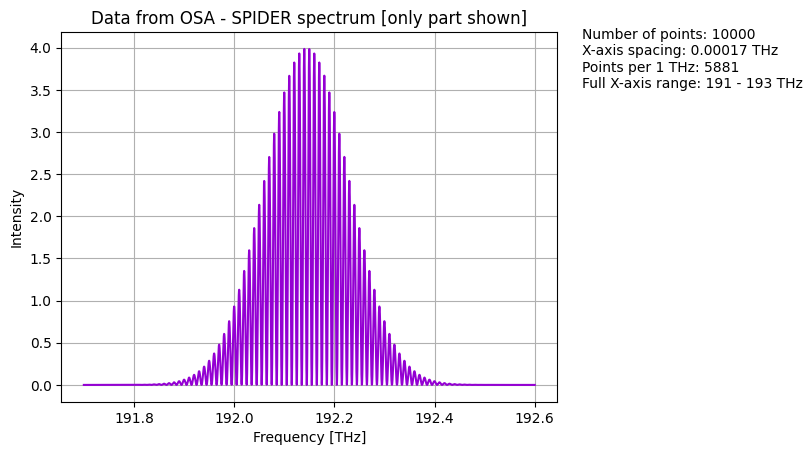

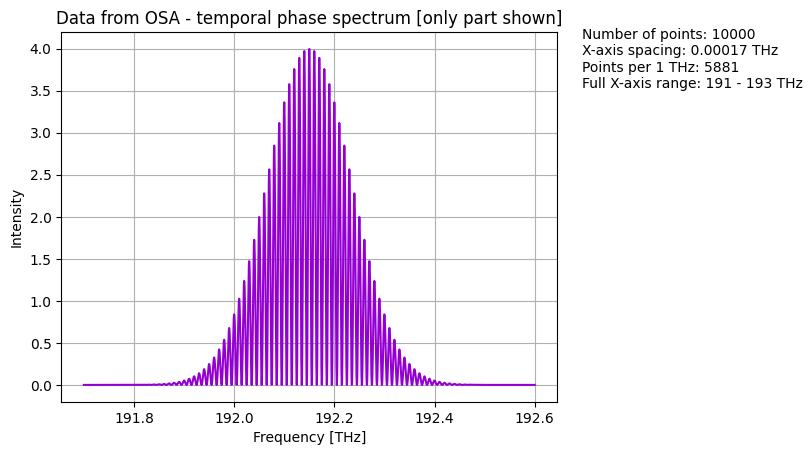

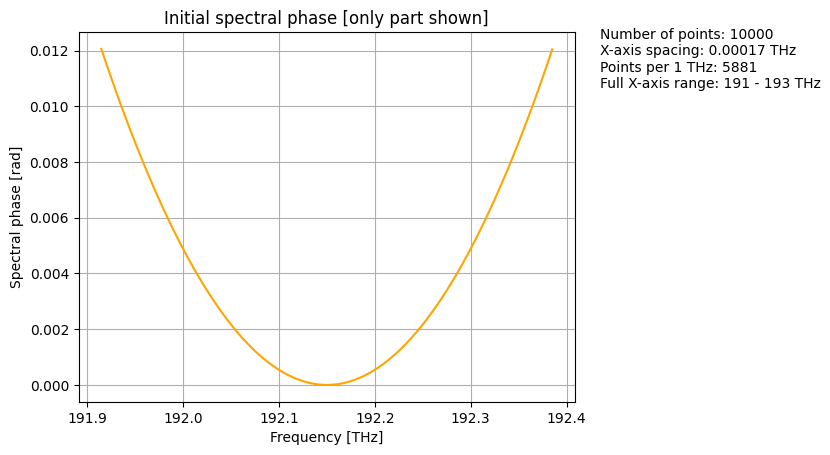

In [20]:
import spectral_analysis as sa
import pandas as pd
import numpy as np
from math import floor as flr
import matplotlib.pyplot as plt

import importlib
import sys
module = sys.modules["spectral_analysis"]
importlib.reload(module)

# pulse function

def gaussian(omega, mu, sig):
    return np.exp(-np.power(omega - mu, 2.) / (2 * np.power(sig, 2.)))

def phase(omega, mu, fiber_length):
    l_0 = 1550
    c = 3*1e8
    D_l = 17
    return np.exp(l_0**2*D_l*fiber_length/(4*np.pi*c)*(omega-mu)**2*1000)

def pulse(omega, mu, sig, fiber_length):
    return gaussian(omega, mu, sig)*np.exp(1j * phase(omega, mu, fiber_length))

pulse = np.vectorize(pulse)
gaussian = np.vectorize(gaussian)

# meta

mean = 192.15
sd = 0.12

time_delay = 100
shear = 0.01
fiber = 0.02 # km

# SPIDER SPECTRUM

line = np.linspace(191.3, 193, 10000)
integrate_interval = flr(shear/(line[1]-line[0]))

y = pulse(line + shear, mean, sd, fiber)*np.exp(1j*time_delay*line*2*np.pi) + pulse(line, mean, sd, fiber)
y = y * np.conjugate(y)

# noise

if False: 

    offset = gaussian(line, mean, sd)*np.conjugate(gaussian(line, mean, sd))*(np.sin(line*2*np.pi/0.1)+1.5)*0.5
    y += offset

    random_noise = gaussian(line, mean, sd)*np.conjugate(gaussian(line, mean, sd))*np.random.uniform(high = 0.1, size = len(line))
    y += random_noise

# plot OSA

spider_spectrum = pd.DataFrame(np.transpose(np.stack([line, y])))
sa.plot(spider_spectrum, x_type = "freq", title = "Data from OSA - SPIDER spectrum", start = 191.7, end = 192.6)

# JUST TEMPORAL PHASE

line = np.linspace(191.3, 193, 10000)

y2 = pulse(line, mean, sd, fiber)*np.exp(1j*time_delay*line*2*np.pi) + pulse(line, mean, sd, fiber)
y2 = y2 * np.conjugate(y2)

# noise

if False: 

    offset = gaussian(line, mean, sd)*np.conjugate(gaussian(line, mean, sd))*(np.sin(line*2*np.pi/0.08)+1.7)*0.4
    y2 += offset

    random_noise = gaussian(line, mean, sd)*np.conjugate(gaussian(line, mean, sd))*np.random.uniform(high = 0.1, size = len(line))
    y2 += random_noise

# plot OSA

temporal_spectrum = pd.DataFrame(np.transpose(np.stack([line, y2])))
sa.plot(temporal_spectrum, x_type = "freq", title = "Data from OSA - temporal phase spectrum", start = 191.7, end = 192.6)

# amplitude of initial pulse

init_pulse = pd.DataFrame(np.transpose(np.stack([line, pulse(line, mean, sd, fiber)])))
#sa.plot(init_pulse, title = "Initial pulse amplitude", type = "freq")

# initial phase

ph = np.angle(pulse(line, mean, sd, fiber))
ph = np.unwrap(ph)
init_phase = pd.DataFrame(np.transpose(np.stack([line, ph])))

min_phase = sa.quantile(init_pulse, 0.025)
max_phase = sa.quantile(init_pulse, 0.975)

idx = np.searchsorted(init_phase.values[:, 0], 192.15)
init_phase.values[:,1] -= init_phase.values[idx,1]

sa.plot(init_phase, title = "Initial spectral phase", color = "orange", start = min_phase, end = max_phase, what_to_plot = "real", x_type = "freq", y_type = "phase")

# pulse in time

time_pulse = sa.recover_pulse(init_phase, init_pulse)
# sa.plot(time_pulse, type = "time", min = -50, max = 100, color = "red", title = "Pulse shape")

# Simulation

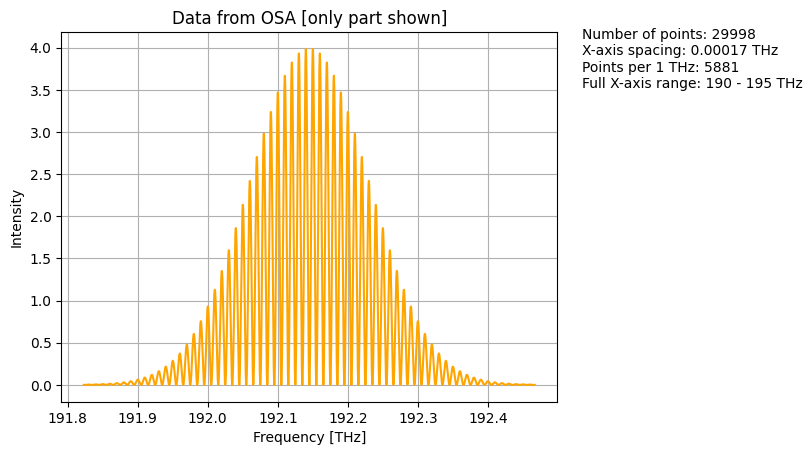

(-100.3821174239661+0j)
(100.3821174239661+0j)


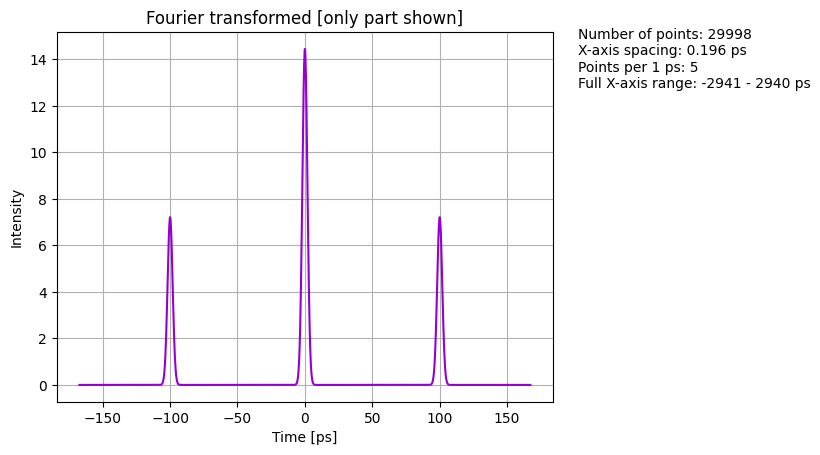

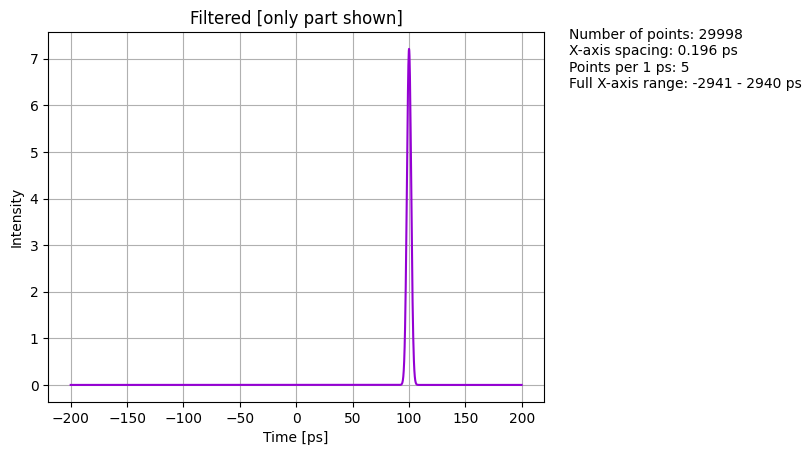

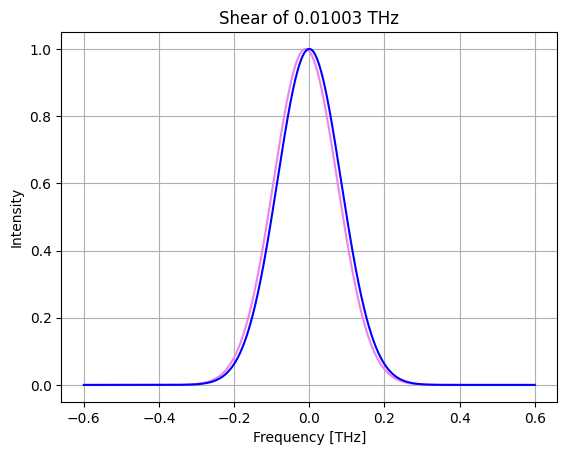

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\spectral_analysis.py:881: ComplexWarning: Casting complex values to real discards the imaginary part
  integrate_interval = flr(shear/(np.mean(np.diff(s_freq_for_later.values[:, 0]))))


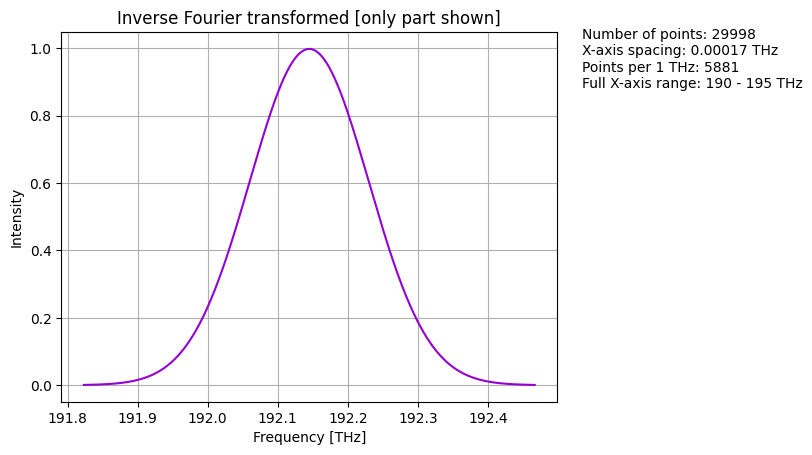

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


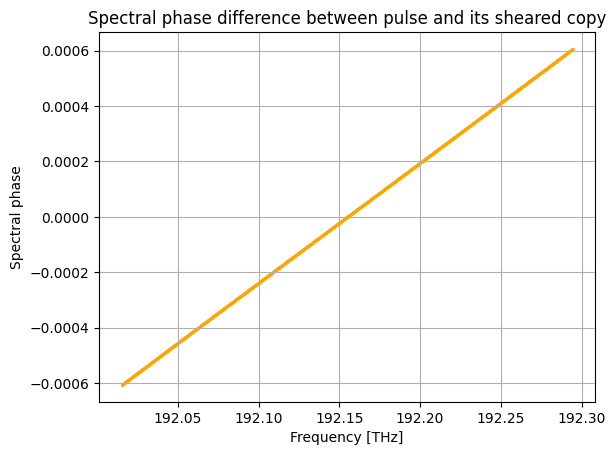

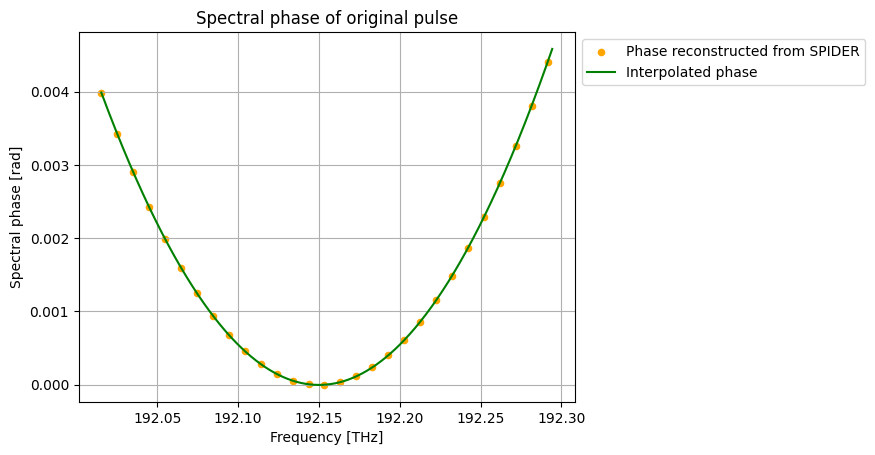

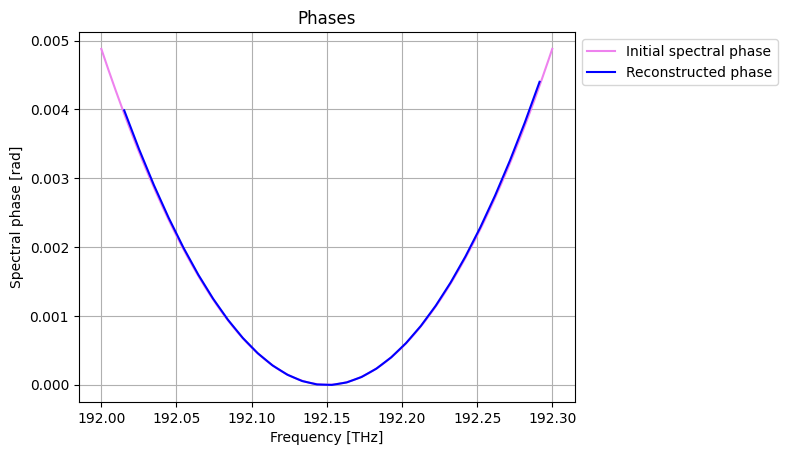

In [21]:
import spectral_analysis as sa
import importlib
import sys
module = sys.modules["spectral_analysis"]
importlib.reload(module)

new_phase = sa.spider(phase_spectrum = spider_spectrum,
        temporal_spectrum = temporal_spectrum,
        shear = None,
        intensity_spectrum = None,
        spectrum_in = "freq",
        what_to_return = "phase",
        plot_steps = True,
        plot_phase = True,
        plot_pulse = False)[0]

sa.compare_plots(spectra = [init_phase, new_phase],
                 title = "Phases",
                 legend = ["Initial spectral phase", "Reconstructed phase"],
                 y_type = "phase",
                 x_type = "freq",
                 start = 192,
                 end = 192.3,
                 abs = False)